# Naive Bayes Code Along and Independent Practice with Yelp review text

## Task 1

Read `yelp.csv` into a DataFrame.

In [1]:
# access yelp.csv using a relative path
import pandas as pd
yelp = pd.read_csv('yelp.csv')
yelp.head(1)

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0


## Task 2

Create a new DataFrame that only contains the 5-star and 1-star reviews.

In [2]:
# filter the DataFrame using an OR condition
yelp_best_worst = yelp[(yelp.stars==5) | (yelp.stars==1)]

## Task 3

Split the new DataFrame into training and testing sets, using the review text as the only feature and the star rating as the response.

In [3]:
# define X and y
X = yelp_best_worst.text
y = yelp_best_worst.stars

In [4]:
# split into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

## Task 4

Use CountVectorizer to create document-term matrices from X_train and X_test.

In [5]:
# import and instantiate the vectorizer
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()

In [6]:
# fit and transform X_train, but only transform X_test
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)
print(X_train_dtm.shape,X_test_dtm.shape)

((3064, 16825), (1022, 16825))


## Task 5

Use Naive Bayes to predict the star rating for reviews in the testing set, and calculate the accuracy.

In [7]:
# import/instantiate/fit
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [8]:
# make class predictions
y_pred_class = nb.predict(X_test_dtm)

In [9]:
# calculate accuracy
from sklearn import metrics
print metrics.accuracy_score(y_test, y_pred_class)

0.918786692759


## Task 6

Calculate the AUC.

In [10]:
# y_test contains fives and ones, which will confuse the roc_auc_score function
y_test[:10].values

array([5, 5, 5, 5, 5, 1, 1, 5, 5, 5], dtype=int64)

In [11]:
# create y_test_binary, which contains ones and zeros instead
import numpy as np
y_test_binary = np.where(y_test==5, 1, 0)
y_test_binary[:10]

array([1, 1, 1, 1, 1, 0, 0, 1, 1, 1])

In [12]:
# predict class probabilities
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]

In [13]:
# calculate the AUC using y_test_binary and y_pred_prob
print metrics.roc_auc_score(y_test_binary, y_pred_prob)

0.939163510429


## Task 7

Plot the ROC curve.

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

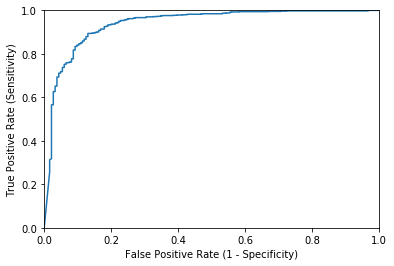

In [15]:
# plot ROC curve using y_test_binary and y_pred_prob
fpr, tpr, thresholds = metrics.roc_curve(y_test_binary, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

## Task 8

Print the confusion matrix, and calculate the sensitivity and specificity. Comment on the results.

In [16]:
# print the confusion matrix


In [17]:
# calculate sensitivity


In [18]:
# calculate specificity


Is the model having a much harder or much easier time detecting five-star reviews than one-star reviews?

In [19]:
### Your answer ###


## Task 9

Browse through the review text for some of the false positives and false negatives. Based on your knowledge of how Naive Bayes works, do you have any theories about why the model is incorrectly classifying these reviews?

In [40]:
# print the first 10 false positives (i.e. those that were incorrectly classified as 1 instead of 0)


Take a moment to study the list of misclassified examples. Is there a pattern in words you see? 

In [41]:
# false positives reason #1: Is the model reacting to  words such as "good", "impressive", "nice", etc.?
#X_test[1781]

In [42]:
# false positives reason #2: The model probably has never seen words like these in the training data! 
# How can you get rid of them in the train and test data? Is there a list of stop and safe words? 
#X_test[9984]

In [23]:
# false positives reason #3: The model does not have enough data to work with.
# X_test[1919]

In [24]:
# Study the first 10 false negatives (meaning they were incorrectly classified as 0 instead of 1)


In [25]:
# false negatives reason #1: Is the model reacting to words like: "complain", "crowds", "rushing", "pricey", "scum"


## Task 10

Let's pretend that you want to balance sensitivity and specificity. You can achieve this by changing the threshold for predicting a 5-star review. What threshold approximately balances sensitivity and specificity?

In [26]:
# create a list that will store the results of the process below
results = []

# loop through the thresholds returned by the metrics.roc_curve function
for threshold in thresholds:
    
    # make a class prediction of 5 if the predicted probability is higher than the threshold
    y_pred_class = np.where(y_pred_prob > threshold, 5, 1)
    
    # generate the confusion matrix and slice it into four pieces
    confusion = metrics.confusion_matrix(y_test, y_pred_class)
    TP = confusion[1][1]
    TN = confusion[0][0]
    FP = confusion[0][1]
    FN = confusion[1][0]
    
    # calculate the sensitivity and specificity
    sensitivity = TP / float(TP + FN)
    specificity = TN / float(TN + FP)
    
    # calculate the absolute difference between sensitivity and specificity
    difference = np.absolute(sensitivity - specificity)
    
    # append a tuple to the results list
    results.append((difference, sensitivity, specificity, threshold))

In [27]:
# locate the minimum difference (at which sensitivity and specificity are balanced)
min(results)

(0.0032816229116945372, 0.87828162291169454, 0.875, 0.99818742360290647)

At a threshold of approximately **0.998**, the sensitivity and specificity are both approximately **0.875**.

## Task 10 (alternative solution)

This solution simplifies the for loop by utilizing the "fpr" and "tpr" objects returned by the `metrics.roc_curve` function.

In [28]:
# create a list that will store the results of the process below
results = []

# loop through the thresholds returned by the metrics.roc_curve function (skipping the first threshold)
for threshold in thresholds[1:]:
    
    # calculate the sensitivity and specificity
    sensitivity = tpr[thresholds > threshold][-1]
    specificity = 1 - fpr[thresholds > threshold][-1]
    
    # calculate the absolute difference between sensitivity and specificity
    difference = np.absolute(sensitivity - specificity)
    
    # append a tuple to the results list
    results.append((difference, sensitivity, specificity, threshold))

In [29]:
# locate the minimum difference (at which sensitivity and specificity are balanced)
min(results)

(0.004474940334128874, 0.87947494033412887, 0.875, 0.99812775398861042)

## Task 11

Let's see how well Naive Bayes performs when all reviews are included, rather than just 1-star and 5-star reviews:

- Define X and y using the original DataFrame from step 1. (y should contain 5 different classes.)
- Split the data into training and testing sets.
- Calculate the testing accuracy of a Naive Bayes model.
- Compare the testing accuracy with the null accuracy.
- Print the confusion matrix.
- Comment on the results.

In [30]:
# define X and y using the original DataFrame but including all stars and the text field only


In [31]:
# split into training and testing sets


In [32]:
# create document-term matrices


In [33]:
# fit a Naive Bayes model


In [34]:
# make class predictions


In [35]:
# calculate the testing accuary


In [39]:
# calculate the null accuracy


In [38]:
# print the confusion matrix


Comments:

- Nearly all 4-star and 5-star reviews are classified as 4 or 5 stars, but they are hard for the model to distinguish between.
- 1-star, 2-star, and 3-star reviews are often classified as 4 stars, probably because it's the predominant class in the training data.
- When the model predicts 1 or 2 stars, it's usually correct.
- 47% accuracy is relatively impressive, given that humans would also have a hard time precisely identifying the star rating for many of these reviews.